# Inverted emissions

In [ ]:
%cd ..

In [2]:
import pathlib
import numpy as np
import pandas as pd
import openpyxl
from scipy.interpolate import make_smoothing_spline
from mce.core import ScenarioBase
from mce.core.forcing import RfAll
from mce.util.plot_base import PlotBase

In [3]:
forcing = RfAll()
myplt = PlotBase(palette='ipcc_wg1')

## Input data

In [4]:
path_indicator = pathlib.Path('../ClimateIndicator')

In [5]:
path = path_indicator.joinpath('GHG-Emissions-Assessment/results/ghg_emissions_co2e_2024.xlsx')
wb = openpyxl.load_workbook(path, read_only=True, data_only=True)
rows = wb['data_original_units'].iter_rows(
    max_col=5, max_row=1159, values_only=True,
)
columns = next(rows)
df = pd.DataFrame(list(rows), columns=columns)
wb.close()

In [6]:
id_vars = ['label', 'source', 'units']
df_2024 = pd.concat({
    k:
    v
    .drop(id_vars, axis=1).set_index('year')
    .squeeze().rename(int).rename_axis(None)
    for k, v in df.groupby(id_vars)
}, axis=1)
df_2024

CH4                      CO2-FFI        N2O                  
     GFED v4.1* PRIMAP CR v2.5.1* GCB v2023* GFED v4.1* PRIMAP CR v2.5.1*
          MtCH4             MtCH4      GtCO2      MtN2O             MtN2O
1750     11.317              26.9        NaN      0.763             0.121
1751     11.103              27.0        NaN      0.751             0.123
1752     10.994              27.1        NaN      0.747             0.124
1753     11.087              27.1        NaN      0.748             0.125
1754     11.361              27.2        NaN      0.766             0.126
...         ...               ...        ...        ...               ...
2019     17.840             305.0  36.327923      0.997            10.300
2020     12.700             303.0  34.274739      0.859            10.400
2021     15.580             307.0  36.049642      1.058            10.500
2022     10.320             312.0  36.379452      0.706            10.600
2023     22.170               NaN        NaN      1.376               NaN

[274 rows x 5 columns]

In [7]:
# Tentative update for 2023 with PRIMAP v2.6 based on changes from 2022
# csv data were downloaded at
# https://primap.org/primap-hist/#scenario=histcr&id=earth&entity=ch4
# and
# https://primap.org/primap-hist/#scenario=histcr&id=earth&entity=n2o
df = pd.DataFrame({
    gas:
    pd.read_csv(f'datain/PRIMAP/v2.6/HISTCR_EARTH_{gas}_Mt.csv', index_col=0)
    .sum(axis=1)
    for gas in ['CH4', 'N2O']
}).rename_axis(None)

d1 = df.loc[2023] - df.loc[2022]
df = df_2024.copy()

for gas in ['CH4', 'N2O']:
    unit = f'Mt{gas}'
    df.loc[2023, (gas, 'PRIMAP CR v2.5.1*', unit)] = (
        df.loc[2022, (gas, 'PRIMAP CR v2.5.1*', unit)]
        + d1[gas]
    )

df_2024_u = df
df_2024_u.loc[2022:]

CH4                      CO2-FFI        N2O                  
     GFED v4.1* PRIMAP CR v2.5.1* GCB v2023* GFED v4.1* PRIMAP CR v2.5.1*
          MtCH4             MtCH4      GtCO2      MtN2O             MtN2O
2022      10.32           312.000  36.379452      0.706            10.600
2023      22.17           311.661        NaN      1.376            10.651

In [8]:
path = path_indicator.joinpath('GHG-Emissions-Assessment/results/ghg_emissions_co2e_2025.xlsx')
wb = openpyxl.load_workbook(path, read_only=True, data_only=True)
rows = wb['data_original_units'].iter_rows(
    max_col=5, max_row=679, values_only=True,
)
columns = next(rows)
df = pd.DataFrame(list(rows), columns=columns)
wb.close()

In [9]:
df_2025 = pd.concat({
    k: v
    .drop(id_vars, axis=1).set_index('year')
    .squeeze().rename(int).rename_axis(None)
    for k, v in df.groupby(id_vars)#  if k[0] != 'CO2-FFI'
}, axis=1)
df_2025

,CH4,CO2-FFI,CO2-LULUCF,N2O
,PRIMAP TP v2.6.1*,GCB v2024*,GCB v2024*,PRIMAP TP v2.6.1*
,MtCH4,GtCO2,GtCO2,MtN2O
1750,26.929247,NaN,NaN,0.158815
1751,27.003120,NaN,NaN,0.160849
1752,27.076972,NaN,NaN,0.162796
1753,27.150754,NaN,NaN,0.164743
1754,27.224514,NaN,NaN,0.166690
...,...,...,...,...
2019,314.437300,37.131282,3.789500,10.327369
2020,311.061200,35.152091,3.441497,10.451296


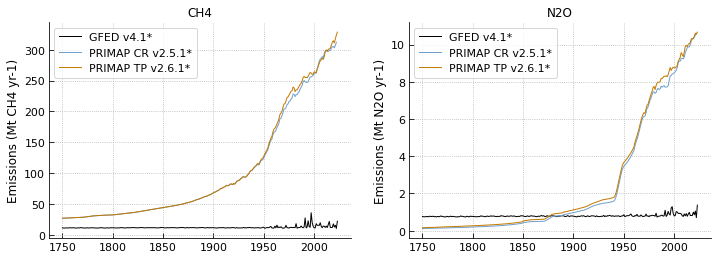

In [10]:
myplt.init_regular(2, col=2)
unit_w = 'Mt'

for ax, gas in zip(myplt(), ['CH4', 'N2O']):
    for k, d1 in df_2024[gas].items():
        ax.plot(d1.index, d1, label=k[0])

    d1 = df_2025[gas].squeeze()
    ax.plot(d1.index, d1, label=d1.name[0])

    ax.legend()
    ax.set_title(gas)
    units = f'{unit_w} {gas} yr-1'
    ax.set_ylabel(f'Emissions ({units})')
    ax.grid()

In [11]:
# Use GFED v4.1 and PRIMAP TP v2.6
df_emis = pd.concat([
    df_2024.T.groupby(level=1).get_group('GFED v4.1*'),
    df_2025.T.groupby(level=1).get_group('PRIMAP TP v2.6.1*'),
]).groupby(level=0).sum().T

In [12]:
df_emis

,CH4,N2O
1750,38.246247,0.921815
1751,38.106120,0.911849
1752,38.070972,0.909796
1753,38.237754,0.912743
1754,38.585514,0.932690
...,...,...
2019,332.277300,11.324369
2020,323.761200,11.310296
2021,332.972250,11.665243
2022,334.123150,11.263134


In [13]:
outpath = 'datain/ds_historical.h5' # created in mk_forcing_ar6__02.ipynb
ds = ScenarioBase(outpath=outpath, mode='a')

[2025-04-23 17:01:28 mce.core] INFO:datain/ds_historical.h5 already exists
[2025-04-23 17:01:28 mce.core] INFO:file datain/ds_historical.h5 opened with mode=a


In [14]:
g = ds.file['historical/input/conc']
df_conc = pd.DataFrame({(k, v.attrs['units']): v for k, v in g.items()}).set_index(('time', 'yr'))
df_conc

,C2F6,C3F8,C7F16,C8F18,CCl4,CF4,CFC-11,CFC-112,CFC-112a,CFC-113,...,Halon-2402,N2O,NF3,SF6,SO2F2,c-C4F8,i-C6F14,n-C4F10,n-C5F12,n-C6F14
,ppt,ppt,ppt,ppt,ppt,ppt,ppt,ppt,ppt,ppt,...,ppt,ppb,ppt,ppt,ppt,ppt,ppt,ppt,ppt,ppt
"(time, yr)",,,,,,,,,,,,,,,,,,,,,
1750,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.0,270.10,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
1751,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.0,270.12,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
1752,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.0,270.14,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
1753,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.0,270.16,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
1754,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.0,270.18,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,4.940000,0.70,0.11984,0.097,77.000,86.40,223.9,0.4,0.0704,69.20,...,0.4,333.30,2.3,10.270,2.600000,1.8114,0.0690,0.2073,0.1528,0.2312
2021,5.030000,0.72,0.12132,0.098,76.000,87.40,221.6,0.4,0.0712,68.60,...,0.4,334.60,2.5,10.650,2.700000,1.8742,0.0704,0.2114,0.1564,0.2328


In [15]:
# Adjust df_conc index
df_conc = df_conc.reindex(df_emis.index)

In [16]:
# Ensure that concentrations are given at 1-year intervals
time = df_conc.index.values
len(time), np.all(time[1:] - time[:-1] == 1)

(274, True)

In [17]:
# Check units
gases = ['CH4', 'N2O']
for k in df_conc.columns:
    if k[0] not in gases:
        continue
    print('{} emis: {}, conc: {}'.format(k[0], f'{unit_w} {k[0]} yr-1', k[1]))

CH4 emis: Mt CH4 yr-1, conc: ppb
N2O emis: Mt N2O yr-1, conc: ppb


## Inverted natural emissions of CH4 and N2O

In [18]:
gases = ['CH4', 'N2O']
unit_c = 'ppb'

w2cs = []
lifes = []

for gas in gases:
    w2cs.append(forcing.weight2conc(1, unit_w, gas, unit_c))
    lifes.append(forcing.ghgs[gas].lifetime)

w2cs = np.array(w2cs)
lifes = np.array(lifes)

In [19]:
lifes, w2cs

(array([ 11.8, 109. ]), array([0.35322459, 0.12873716]))

In [20]:
lam = 200. # control parameter for smoothness and proximity

df_raw = {}
df_spl = {}

for gas, life, w2c in zip(gases, lifes, w2cs):
    # Observed concentrations
    d0 = df_conc[(gas, unit_c)]
    # Inverted emissions (natural + anthropogenic)
    d0_inv = (pd.Series(np.gradient(d0), index=d0.index) + d0 / life) / w2c

    # Anthropogenic emissions
    d1 = df_emis[gas]
    # Inverted natural emissions
    d2 = d0_inv - d1
    spl = make_smoothing_spline(d2.index, d2, lam=lam)
    df_raw[gas] = d2
    df_spl[gas] = pd.Series(spl(d2.index), index=d2.index)

df_raw = pd.DataFrame(df_raw)
df_spl = pd.DataFrame(df_spl)

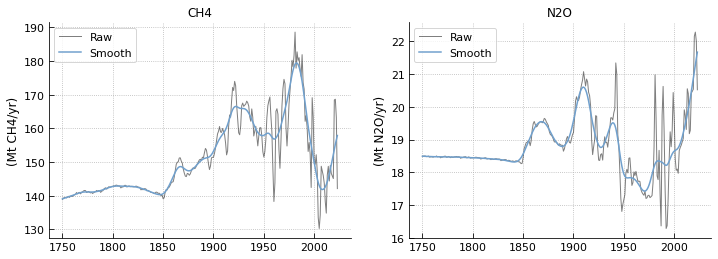

In [21]:
myplt.init_regular(2, col=2)

for ax, gas in zip(myplt(), gases):
    d0 = df_raw[gas].squeeze()
    d1 = df_spl[gas].squeeze()
    ax.plot(d0.index, d0, alpha=0.5, label='Raw')
    ax.plot(d1.index, d1, lw=1.5, label='Smooth')
    ax.legend()
    ax.set_ylabel(f'({unit_w} {gas}/yr)')
    ax.set_title(gas)
    ax.grid()

In [22]:
df_emis_natural = df_spl
df_emis_natural

,CH4,N2O
1750,139.074141,18.490571
1751,139.172481,18.489000
1752,139.270132,18.487388
1753,139.366839,18.485720
1754,139.463202,18.484020
...,...,...
2019,152.298459,20.873796
2020,153.842597,21.081999
2021,155.294753,21.284006
2022,156.633076,21.477942


In [26]:
for df in [df_emis, df_emis_natural]:
    df.columns = pd.MultiIndex.from_tuples([
        (k, f'{unit_w} {k} yr-1') for k in df.columns
    ])

## Inverted emissions of halogens

In [27]:
g = ds.file['historical/input/conc']
df_conc = pd.DataFrame({
    (k, v.attrs['units']): v for k, v in g.items() if k not in ['CO2', 'CH4', 'N2O']
}).set_index(('time', 'yr'))
df_conc

,C2F6,C3F8,C7F16,C8F18,CCl4,CF4,CFC-11,CFC-112,CFC-112a,CFC-113,...,Halon-1301,Halon-2402,NF3,SF6,SO2F2,c-C4F8,i-C6F14,n-C4F10,n-C5F12,n-C6F14
,ppt,ppt,ppt,ppt,ppt,ppt,ppt,ppt,ppt,ppt,...,ppt,ppt,ppt,ppt,ppt,ppt,ppt,ppt,ppt,ppt
"(time, yr)",,,,,,,,,,,,,,,,,,,,,
1750,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.000,0.0,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
1751,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.000,0.0,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
1752,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.000,0.0,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
1753,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.000,0.0,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
1754,0.000001,0.00,0.00000,0.000,0.025,34.05,0.0,0.0,0.0000,0.00,...,0.000,0.0,0.0,0.000,0.000021,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,4.940000,0.70,0.11984,0.097,77.000,86.40,223.9,0.4,0.0704,69.20,...,3.320,0.4,2.3,10.270,2.600000,1.8114,0.0690,0.2073,0.1528,0.2312
2021,5.030000,0.72,0.12132,0.098,76.000,87.40,221.6,0.4,0.0712,68.60,...,3.330,0.4,2.5,10.650,2.700000,1.8742,0.0704,0.2114,0.1564,0.2328


In [28]:
# Ensure that all the units are ppt
set(df_conc.columns.get_level_values(1))

{'ppt'}

In [29]:
df_conc = df_conc.droplevel(1, axis=1)

In [30]:
unit_w = 'kt'
unit_c = 'ppt'

lifes = np.array([forcing.ghgs[gas].lifetime for gas in df_conc])
w2cs = np.array([
    forcing.weight2conc(1, unit_w, gas, unit_c)
    for gas in df_conc
])

In [31]:
# Ensure that input concentrations are given at 1-year intervals
time = df_conc.index.values
np.all(time[1:] - time[:-1] == 1)

True

In [32]:
# Inverted emissions
yin = df_conc.values
xinv = (np.gradient(yin, axis=0) + yin / lifes) / w2cs

In [33]:
df_emis_inv = pd.DataFrame(xinv, index=time, columns=df_conc.columns)

In [34]:
df_emis_inv

,C2F6,C3F8,C7F16,C8F18,CCl4,CF4,CFC-11,CFC-112,CFC-112a,CFC-113,...,Halon-1301,Halon-2402,NF3,SF6,SO2F2,c-C4F8,i-C6F14,n-C4F10,n-C5F12,n-C6F14
1750,3.139314e-09,0.000000,0.000000,0.000000,0.021211,0.010577,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000
1751,3.139314e-09,0.000000,0.000000,0.000000,0.021211,0.010577,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000
1752,3.139314e-09,0.000000,0.000000,0.000000,0.021211,0.010577,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000
1753,3.139314e-09,0.000000,0.000000,0.000000,0.021211,0.010577,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000
1754,3.139314e-09,0.000000,0.000000,0.000000,0.021211,0.010577,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,2.204322e+00,0.672645,0.104102,0.079818,39.536066,14.782239,48.631490,0.226264,0.077487,4.765295,...,1.343334,0.655118,2.556955,9.105593,3.102341,2.212444,0.084858,0.175600,0.184909,0.099912
2021,2.569923e+00,0.672900,0.104136,0.079843,37.330191,16.335750,47.559079,0.226264,0.078040,6.205552,...,1.346984,0.655118,2.561359,10.010940,3.152378,2.237850,0.084885,0.175666,0.184954,0.099943
2022,2.083040e+00,0.673156,0.104170,0.079869,33.766855,12.453092,46.486668,0.226264,0.078594,7.681371,...,1.215571,0.655118,2.565764,9.627388,3.202416,2.238543,0.084912,0.175733,0.184998,0.099974
2023,1.924830e+00,0.673411,0.104204,0.079895,33.834728,12.375587,45.414258,0.226264,0.079147,6.015296,...,1.281277,0.655118,2.570169,9.307963,3.252454,2.239236,0.084939,0.175799,0.185043,0.100005


In [35]:
# Reference data for comparison
path = path_indicator.joinpath('forcing-timeseries/output/ghg_equivalent_emissions.csv')
df_emis_ref = pd.read_csv(path, index_col=0).rename(int)

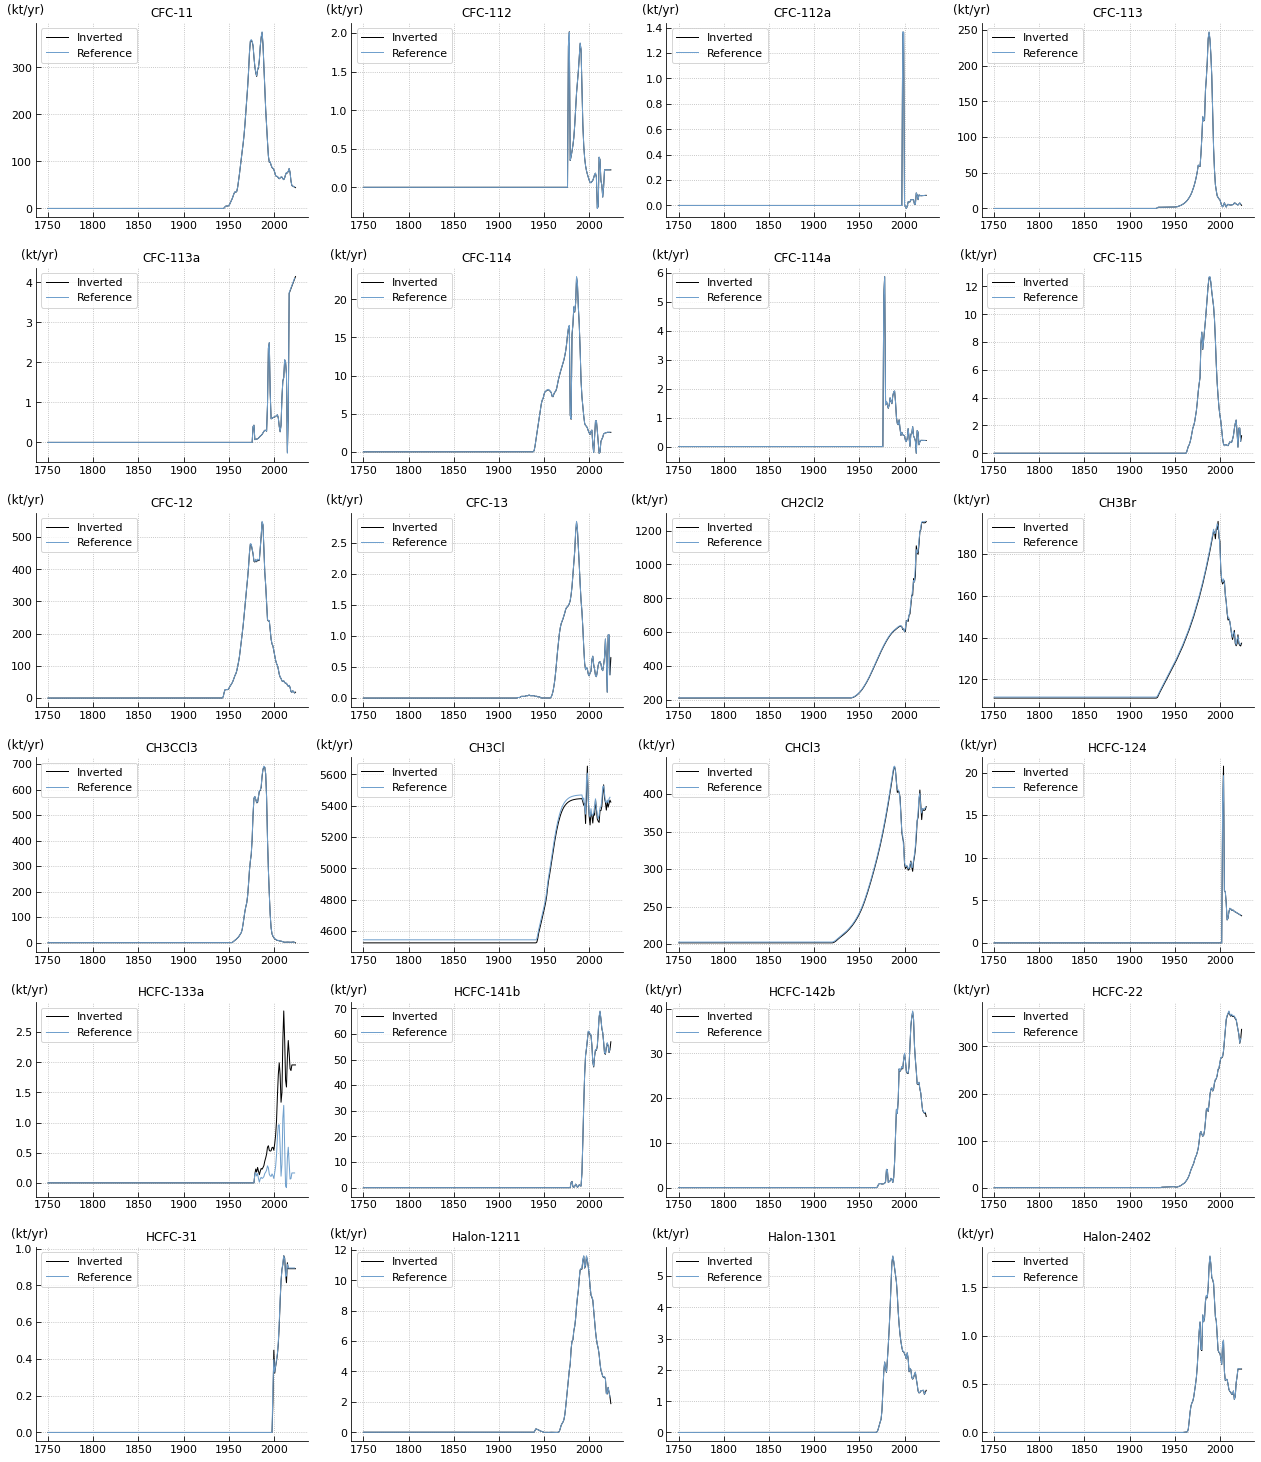

In [36]:
gases = [
    # chlorofluorocarbons (CFC), hydrofluorochlorocarbons (HCFC),
    # chlorocarbons, hydrochlorocarbons,
    # bromocarbons, hydrobromocarbons, and halons
    'CFC-11', 'CFC-112', 'CFC-112a', 'CFC-113', 'CFC-113a', 'CFC-114',
    'CFC-114a', 'CFC-115', 'CFC-12', 'CFC-13', 'CH2Cl2',
    'CH3Br', 'CH3CCl3', 'CH3Cl', 'CHCl3',
    'HCFC-124', 'HCFC-133a', 'HCFC-141b', 'HCFC-142b', 'HCFC-22', 'HCFC-31',
    'Halon-1211', 'Halon-1301', 'Halon-2402',
]
kw_space = {'height': 2.7, 'wspace': 0.6}
kw_ylabel = {
    'rotation': 'horizontal',
    'x': 0., 'y': 1.03, 'ha': 'left', 'va': 'bottom',
}

myplt.init_regular(len(gases), col=4, kw_space=kw_space)

for ax, gas in zip(myplt(), gases):
    d0 = df_emis_inv[gas]
    d1 = df_emis_ref[gas]
    ax.plot(d0.index, d0, label='Inverted')
    ax.plot(d1.index, d1, label='Reference')
    ax.legend()
    ax.set_title(gas)
    units = f'{unit_w}/yr'
    ax.set_ylabel(f'({units})', **kw_ylabel)
    ax.grid()

In [37]:
# Significat differences found in HCFC-133a may be related to its lifetime difference
forcing.ghgs['HCFC-133a']

Molecule(name='HCFC-133a', category='montreal_gases', formula='CH2ClCF3', weight=118.49, efficiency=0.14995, lifetime=4.6)

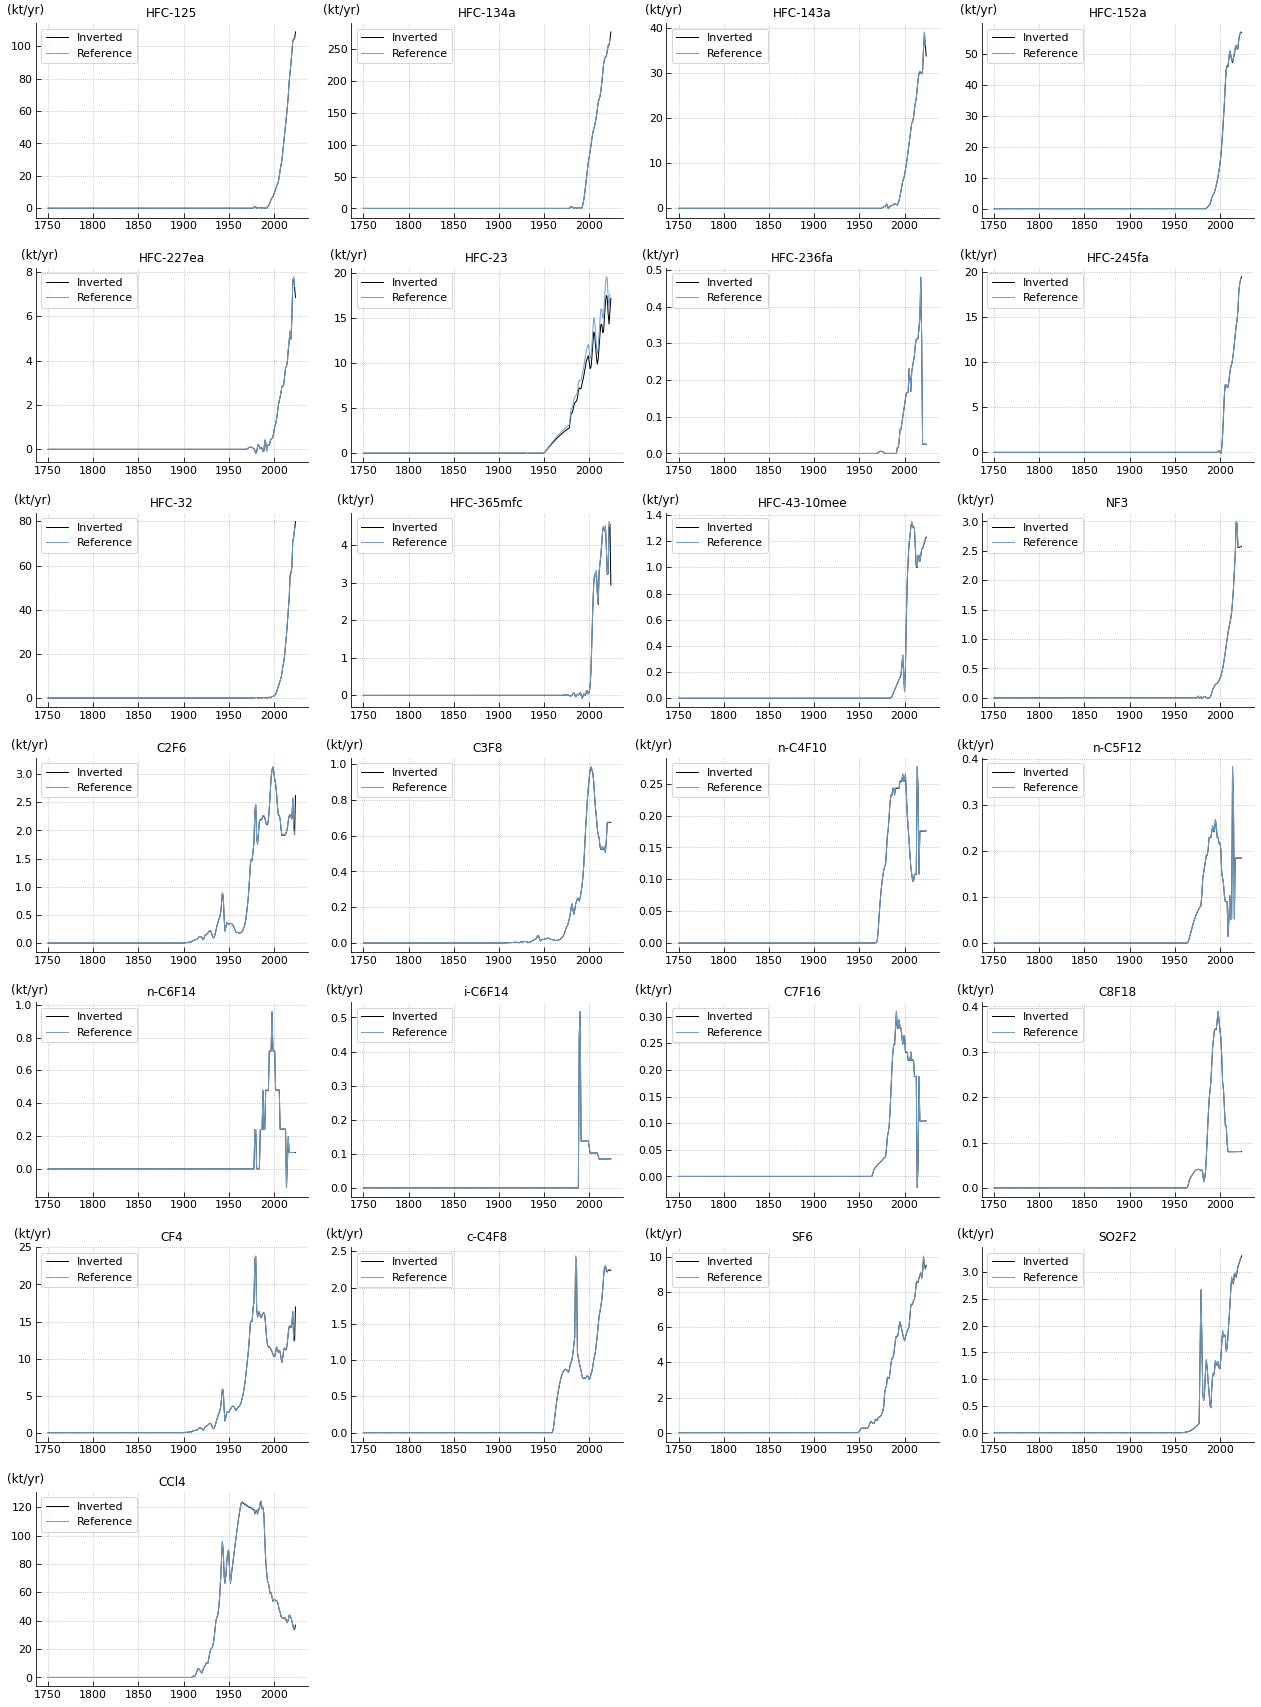

In [38]:
gases = [
    # hydrofluorocarbons (HFC) and fully fluorinated species including perfluorocarbons (PFCs)
    'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23',
    'HFC-236fa', 'HFC-245fa', 'HFC-32', 'HFC-365mfc', 'HFC-43-10mee',
    'NF3', 'C2F6', 'C3F8', 'n-C4F10', 'n-C5F12', 'n-C6F14', 'i-C6F14',
    'C7F16', 'C8F18', 'CF4', 'c-C4F8', 'SF6', 'SO2F2', 'CCl4',
]

myplt.init_regular(len(gases), col=4, kw_space=kw_space)

for ax, gas in zip(myplt(), gases):
    d0 = df_emis_inv[gas]
    d1 = df_emis_ref[gas]
    ax.plot(d0.index, d0, label='Inverted')
    ax.plot(d1.index, d1, label='Reference')
    ax.legend()
    ax.set_title(gas)
    units = f'{unit_w}/yr'
    ax.set_ylabel(f'({units})', **kw_ylabel)
    ax.grid()

In [40]:
df_emis_inv.columns = pd.MultiIndex.from_tuples([
    (k, f'{unit_w} {k} yr-1') for k in df_emis_inv.columns
])

## Save data

In [50]:
for cat, df in [
    ('emis_ghg', pd.concat([df_emis, df_emis_inv], axis=1)),
    ('emis_natural', df_emis_natural),
]:
    g = ds.file['historical/input'].create_group(cat)

    for k, v in df.rename_axis('time').reset_index(col_fill='yr').items():
        d = g.create_dataset(k[0], data=v)
        d.attrs['units'] = k[1]

In [51]:
ds.close()

[2025-04-23 17:15:35 mce.core] INFO:file datain/ds_historical.h5 closed
